# Covariance vs. Entropic Inference---Finite Shot Regime



In [1]:
import qnetti
import pennylane as qml
from pennylane import numpy as qnp
import qnetvo
import matplotlib.pyplot as plt
from functools import reduce

print(qnetvo.__version__)
print(qml.__version__)

0.4.1
0.28.0


In [7]:
qnp.random.seed(100)


def characteristic_matrix_inference(prep_node, num_steps, step_size, shots):
    vn_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    mi_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    dev_kwargs = {"shots": shots}
    char_mat, mi_opt_dict, vn_opt_dict = qnetti.optimize_characteristic_matrix(
        prep_node, vn_opt_kwargs=vn_opt_kwargs, mi_opt_kwargs=mi_opt_kwargs, dev_kwargs=dev_kwargs
    )
    return char_mat


def covariance_matrix_inference(prep_node, num_steps, step_size, shots):
    cov_mat, opt_dict = qnetti.optimize_covariance_matrix(
        prep_node, step_size=step_size, num_steps=num_steps, dev_kwargs={"shots": shots}
    )
    return cov_mat

In [80]:
def plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=0, idx_2=1):
    plt.plot(
        shots_list,
        [reduce(lambda x, y: x + y, mat)[idx_1, idx_2] / trial for mat in char_mat_data],
        label="avg mutual information (bits)",
        color="#1f77b4",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[idx_1, idx_2] / trial
            for mat in cov_mat_data
        ],
        label="avg covariance",
        color="#ff7f0e",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[idx_1, idx_2] for mat in char_mat_data],
        label="max mutual information (bits)",
        color="#1f77b4",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[idx_1, idx_2]
            for mat in cov_mat_data
        ],
        label="max covariance",
        color="#ff7f0e",
    )
    plt.xlabel("number of shots")
    plt.ylabel("numerical value")


## Bell Pair Test

In [11]:
def max_entangled_prep_node():
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

In [33]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            max_entangled_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(
            max_entangled_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]

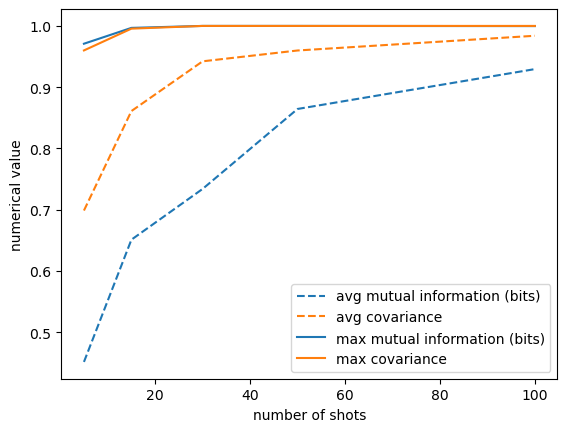

In [34]:
plot_result(shots_list, char_mat_data, cov_mat_data)

## W-state test

In [39]:
def w_state_prep_node():
    def rot_w_state(settings, wires):
        qnetvo.W_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])

    w_state_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=rot_w_state)
    return w_state_prep_node

In [40]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            w_state_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(w_state_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

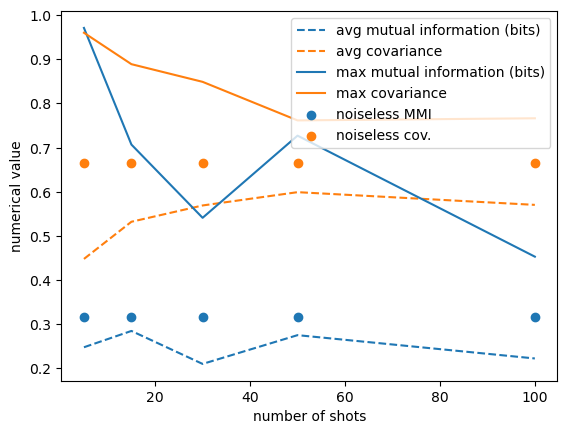

In [57]:
idx_1 = 0
idx_2 = 1

plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)
noiseless_mmi = characteristic_matrix_inference(
    w_state_prep_node(), num_steps=100, step_size=0.05, shots=None
)
noiseless_cov = covariance_matrix_inference(
    w_state_prep_node(), num_steps=100, step_size=0.05, shots=None
)
plt.scatter(
    shots_list,
    [abs(noiseless_mmi[idx_1, idx_2]) for s in shots_list],
    color="#1f77b4",
    label="noiseless MMI",
)
plt.scatter(
    shots_list,
    [noiseless_cov[idx_1, idx_2] for s in shots_list],
    color="#ff7f0e",
    label="noiseless cov.",
)
plt.legend()

The figure above shows a possible advantage of entropic inference. In the low-shot regime, it seems like estimating the entropy is easier to do than estimating the covariance (gap between lines and dots). If we put ourselves strictly in the context of inferring topology, covariance methods has a slight advantage since it is, by nature, further away from zero. However, maybe the precision is needed sometimes. 

# No entanglement test

In [60]:
def loc_rot_prep_node():
    def local_rot_state(settings, wires):
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])

    loc_rot_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=local_rot_state)
    return loc_rot_prep_node

In [61]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            loc_rot_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(loc_rot_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

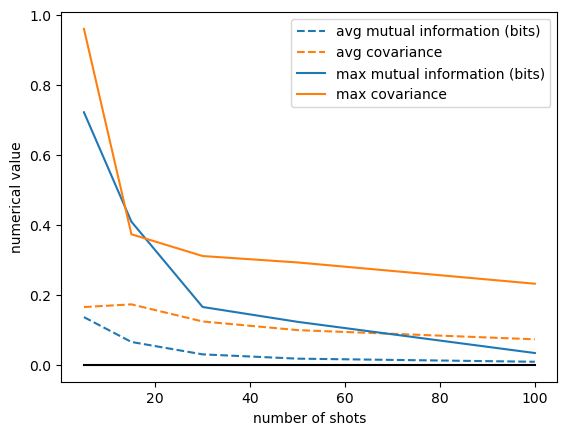

In [62]:
idx_1 = 0
idx_2 = 1

plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)
plt.plot(shots_list, [0 for s in shots_list], "k")
plt.legend()

As we hoped, when no correlation exist, we have a stronger tendency of falsely thinking the qubits are entangled when looking at the covariance, particularly so in the low-shot regime. 

## Full network example 

In [68]:
def network_prep_node():
    def network_state(settings, wires):
        qnetvo.W_state(settings, wires=[wires[0],wires[1],wires[2]])
        qnetvo.ghz_state(settings, wires=[wires[3],wires[4]])
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])
        qml.ArbitraryUnitary([1.3, 5, -0.8], wires=[wires[3]])
        qml.ArbitraryUnitary([5.5, -2.3, 1], wires=[wires[4]])

    prep_node = qnetvo.PrepareNode(wires=[0, 1, 2, 3, 4], ansatz_fn=network_state)
    return prep_node

In [69]:
shots_list = [5, 15, 30, 50, 100]
trial = 30

char_mat_data = [
    [
        characteristic_matrix_inference(
            network_prep_node(), num_steps=30, step_size=0.05, shots=shots
        )
        for t in range(trial)
    ]
    for shots in shots_list
]
cov_mat_data = [
    [
        covariance_matrix_inference(network_prep_node(), num_steps=30, step_size=0.05, shots=shots)
        for t in range(trial)
    ]
    for shots in shots_list
]

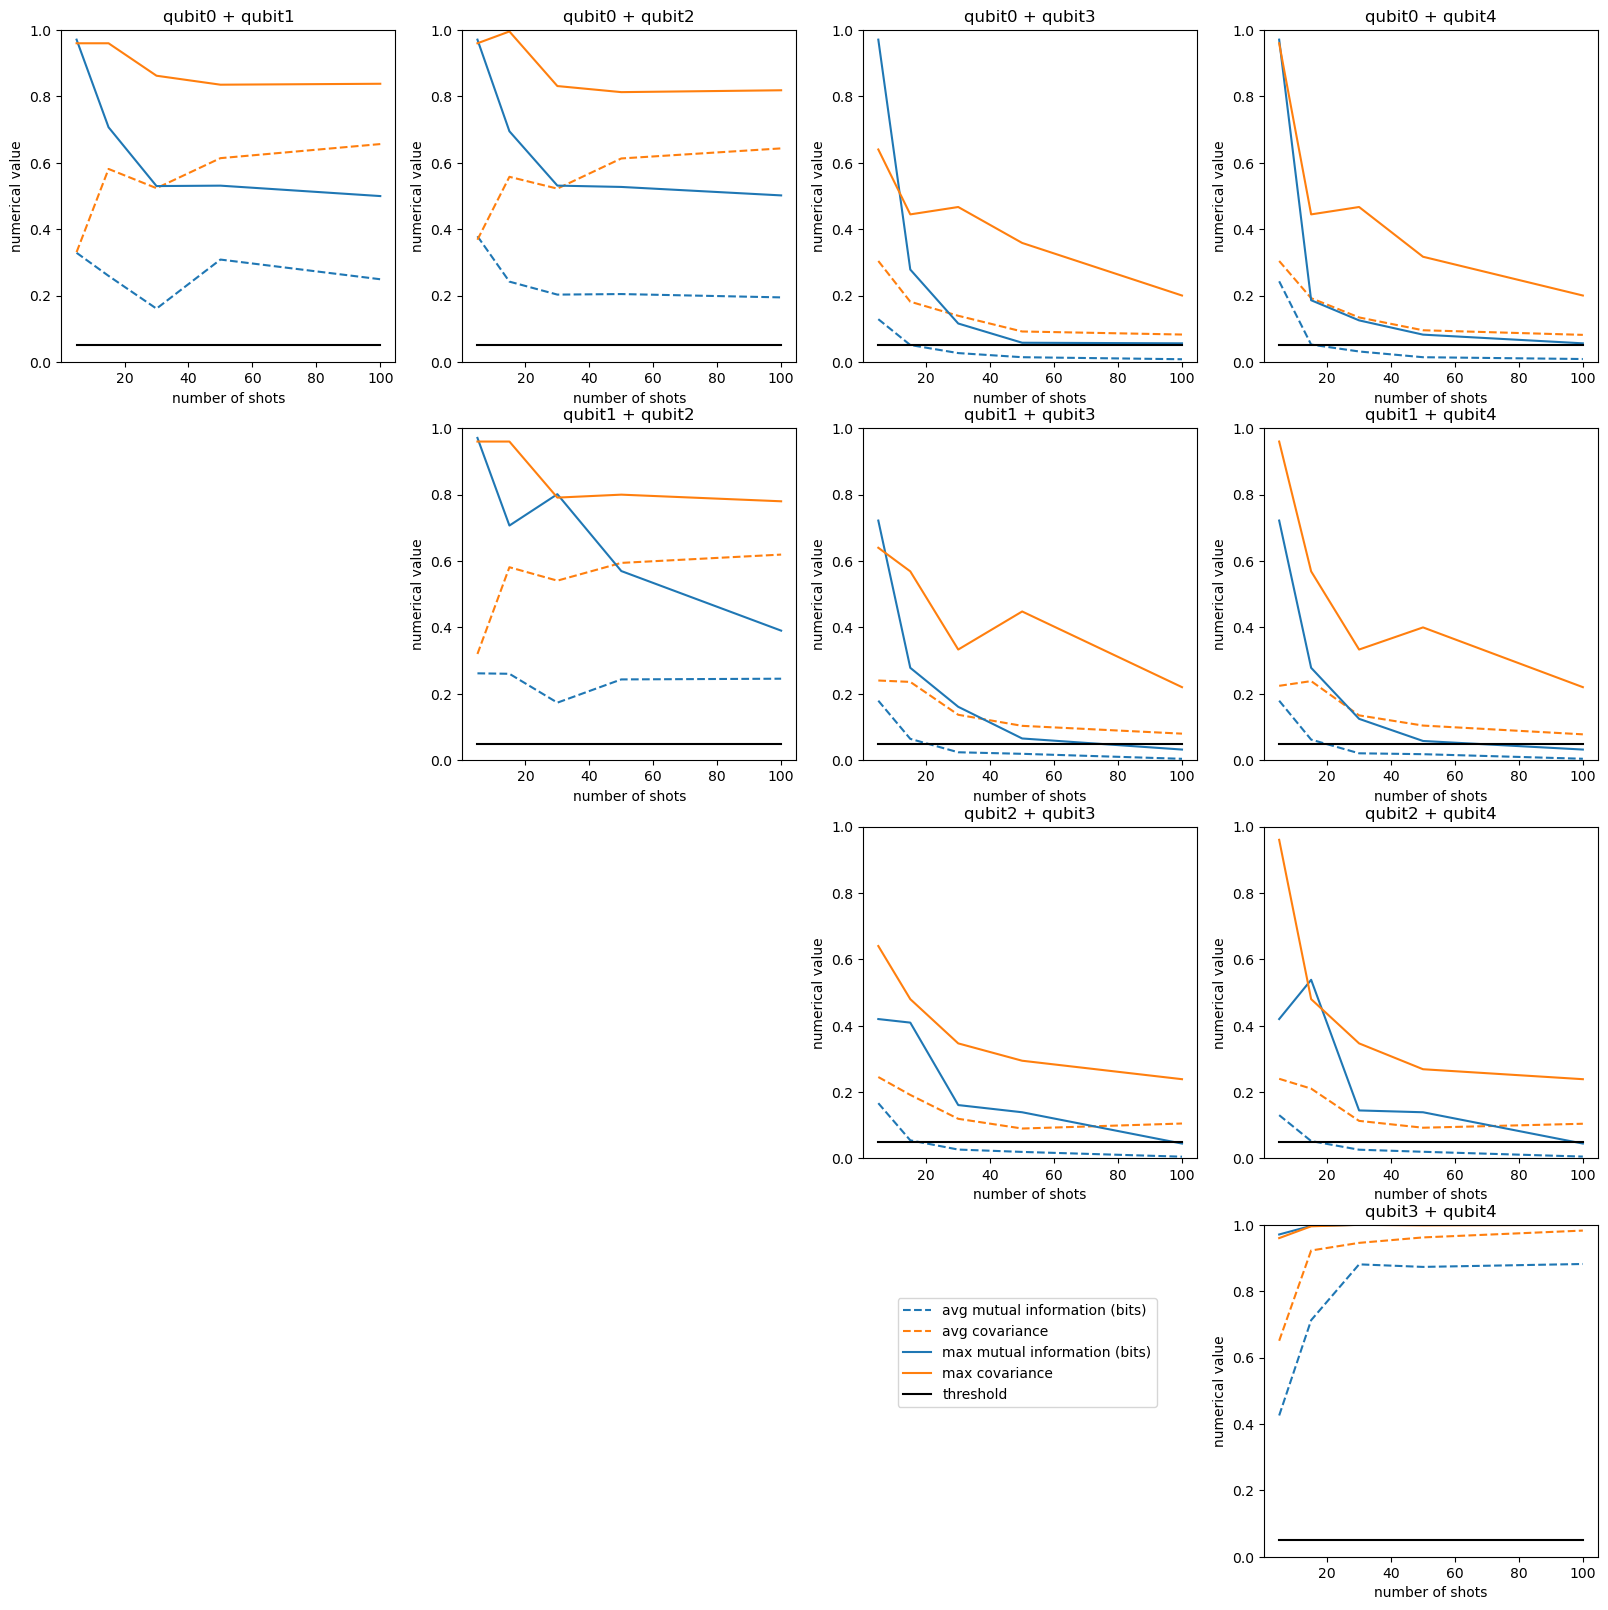

In [101]:
plt.figure(figsize=(25,25))
for i in range(0,5):
    for j in range(i+1, 5):
        plt.subplot(5,5,i*5 + j)

        idx_1 = i
        idx_2 = j

        plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=idx_1, idx_2=idx_2)
        plt.plot(shots_list, [0.05 for s in shots_list], "k", label="threshold")
        plt.title("qubit" + str(idx_1) + " + qubit" + str(idx_2))
        plt.ylim([0,1])
        
plt.legend(bbox_to_anchor=(-0.3, 0.8))